# **Importing libraries**

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import librosa
import torchvision
import numpy as np

import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd

from tqdm import tqdm
%matplotlib inline

from torchsummary import summary


# Get Computtional Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Importing the Dataset

In [3]:
# Percorso base del dataset RAVDESS su Kaggle
# (Kaggle salva automaticamente i dataset nella cartella /kaggle/input/)
DATASET_PATH = "/kaggle/input/datasets/uwrfkaggler/ravdess-emotional-speech-audio"

# Mappatura delle emozioni (il 3° numero nel nome del file RAVDESS)
# Mappatura delle emozioni (Adattata per partire da 0)
emotion_map = {
    0: 'Neutral',
    1: 'Calm',
    2: 'Happy',
    3: 'Sad',
    4: 'Angry',
    5: 'Fearful',
    6: 'Disgust',
    7: 'Surprised'
}

print("Librerie importate con successo!")

Librerie importate con successo!


In [4]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset

class RavdessDataset(Dataset):
    def __init__(self, root_dir=DATASET_PATH, subset="training", emotions=None):
        """
        emotions: lista di stringhe con i codici delle emozioni da tenere (es. ["03", "04"] per Felice e Triste).
                  Se None, prende tutte le emozioni.
        """
        self.root_dir = root_dir
        self.emotions = emotions if emotions is not None else []
        self._walker = [] # Conterrà i percorsi dei file audio selezionati

        # 1. Trova tutti i file .wav nelle sottocartelle
        all_files = []
        for dirpath, _, filenames in os.walk(root_dir):
            for f in filenames:
                if f.endswith(".wav"):
                    all_files.append(os.path.join(dirpath, f))

        # 2. Filtra e suddividi il dataset
        for file_path in all_files:
            filename = os.path.basename(file_path)
            
            # Rimuove ".wav" e divide la stringa usando i trattini
            parts = filename.replace(".wav", "").split("-")
            
            # Controlla che il file sia effettivamente nel formato RAVDESS (7 parti)
            if len(parts) != 7:
                continue
                
            emotion = parts[2]
            actor = int(parts[6]) # Convertiamo in intero per fare i confronti (es. "05" diventa 5)

            # Filtra per etichetta (emozione)
            if len(self.emotions) > 0 and emotion not in self.emotions:
                continue # Salta questo file e passa al prossimo

            # Suddivide per Actor (Previene il data leakage)
            if subset == "training" and actor <= 18:
                self._walker.append(file_path)
            elif subset == "validation" and 19 <= actor <= 22:
                self._walker.append(file_path)
            elif subset == "testing" and actor >= 23:
                self._walker.append(file_path)
            elif subset is None:
                self._walker.append(file_path) # Carica tutto se subset non è specificato

    def __len__(self):
        # PyTorch ha bisogno di sapere quanto è grande il dataset
        return len(self._walker)

    def __getitem__(self, idx):
        file_path = self._walker[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        
        # Prende il nome del file (es: "03-01-05-01-02-01-12.wav")
        filename = os.path.basename(file_path)
        
        # Toglie l'estensione e divide i pezzi
        parts = filename.replace(".wav", "").split("-")
        
        # Estrae i vari ID dal nome del file
        emotion_label = parts[2]
        utterance_number = int(parts[4])  # Frase 1 o 2
        speaker_id = int(parts[6])        # Attore da 1 a 24
        
        # Converte l'etichetta dell'emozione in un tensore
        label_tensor = torch.tensor(int(emotion_label) - 1, dtype=torch.long)
        
        # Ora restituisce anche speaker_id e utterance_number!
        return waveform, sample_rate, label_tensor, speaker_id, utterance_number

In [5]:
# Voglio solo Felicità (03) e Rabbia (05)
emozioni_scelte = ["00","01","02","03","04", "05","06","07"]

train_dataset = RavdessDataset(subset="training", emotions=emozioni_scelte)
val_dataset = RavdessDataset(subset="validation", emotions=emozioni_scelte)
test_dataset = RavdessDataset(subset="testing", emotions=emozioni_scelte)

print(f"File di training trovati: {len(train_dataset)}")
print(f"File di validation trovati: {len(val_dataset)}")

File di training trovati: 1872
File di validation trovati: 416


# Esplorazione dei dati

Sample metadata. Label: 6, Speaker: 2, Utterance no. 1
Shape of waveform: torch.Size([1, 198598])
  Number of channels: 1
  Number of samples: 198598
Sample rate of waveform: 48000 Hz
Seconds: 4.137458333333333 s


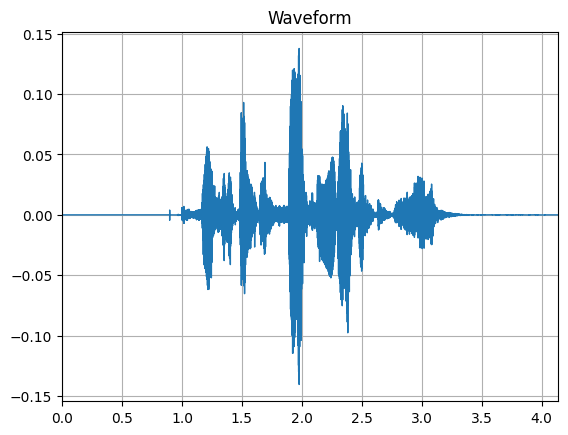

In [6]:
idx = 1 #seleziona un campione dal dataset es. indice=1

waveform, sample_rate, label, speaker_id, utterance_number = train_dataset[idx]

print(f"Sample metadata. Label: {label}, Speaker: {speaker_id}, Utterance no. {utterance_number}")
print("Shape of waveform: {}".format(waveform.size()))
print("  Number of channels: {}".format(waveform.size()[0]))
print("  Number of samples: {}".format(waveform.size()[1]))
print("Sample rate of waveform: {} Hz".format(sample_rate))


# TASK: WAVEFORM PLOT

#traccia la forma d'onda e stampane la forma.
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

num_campioni=waveform.shape[1]
sec=num_campioni/sample_rate
print("Seconds: {} s".format(sec))

plot_waveform(waveform, sample_rate)


Run the following cell and listen to the sample

In [7]:
print(f"Listen to sample no. {idx} with utterance_number: {utterance_number}")
print(f" Speaker {speaker_id} saying '{label}'")
print()
#Ascolta lo stesso campione con "ipd.Audio(<forma d'onda>, )"
ipd.display(ipd.Audio(waveform.numpy(), rate=sample_rate))

Listen to sample no. 1 with utterance_number: 1
 Speaker 2 saying '6'



In [8]:
import pandas as pd

print("Counting number of labels in the dataset (be patient) ...")

# 1. Estrai i valori numerici dal dataset (gestendo sia i tensori che i numeri normali)
raw_labels = [d[2].item() if hasattr(d[2], 'item') else d[2] for d in train_dataset]

# 2. Calcola le frequenze con Pandas
counts = pd.Series(raw_labels).value_counts()

# 3. Ottieni la lista dei nomi delle emozioni (es. ['Happy', 'Sad', ...])
# Uso .get() per sicurezza, così se spunta un numero non previsto non va in crash
labels_testo = [emotion_map.get(lbl, f"Sconosciuto ({lbl})") for lbl in counts.index.tolist()]

# 4. Ottieni il dizionario completo {Nome_Emozione: Conteggio}
label_counts_dict = {emotion_map.get(k, f"Sconosciuto ({k})"): v for k, v in counts.items()}

# Stampa i risultati!
print("Le mie label sono:", labels_testo)
print("I conteggi per ogni label sono:", label_counts_dict)

Counting number of labels in the dataset (be patient) ...
Le mie label sono: ['Disgust', 'Fearful', 'Sad', 'Happy', 'Calm', 'Angry', 'Neutral']
I conteggi per ogni label sono: {'Disgust': 288, 'Fearful': 288, 'Sad': 288, 'Happy': 288, 'Calm': 288, 'Angry': 288, 'Neutral': 144}


# **Ricampionamento**
I file audio del dataset RAVDESS sono originariamente registrati a una frequenza di campionamento (Sample Rate) di 48 kHz (48.000 valori al secondo). Se ricampioni il segnale a 16 kHz, riduci la quantità di dati in ingresso a un terzo.

In [9]:
import torchaudio
import torchaudio.transforms as T

# 1. Definisci le variabili di input (Supponiamo che l'audio sia a 16 kHz)
original_sample_rate = sample_rate # Esempio di frequenza originale
# waveform = ... # tensore PyTorch della forma d'onda

# 2. Definisci la frequenza target
resample_freq = 16000  # Vogliamo ricampionare a 16 kHz

# 3. Inizializza la trasformazione Resample
# Il primo argomento è la frequenza originale, il secondo è la frequenza target.
resampler = T.Resample(
    orig_freq=original_sample_rate,
    new_freq=resample_freq
)

# 4. Applica la trasformazione
waveform_16k = resampler(waveform)

# 5. La nuova frequenza di campionamento è 8000 Hz
new_sample_rate = resample_freq

sample_rate=new_sample_rate
waveform=waveform_16k;

print("sample_rate",sample_rate)

sample_rate 16000


Wavefrom, Spectogram e Filter Bank con Ricampionamento

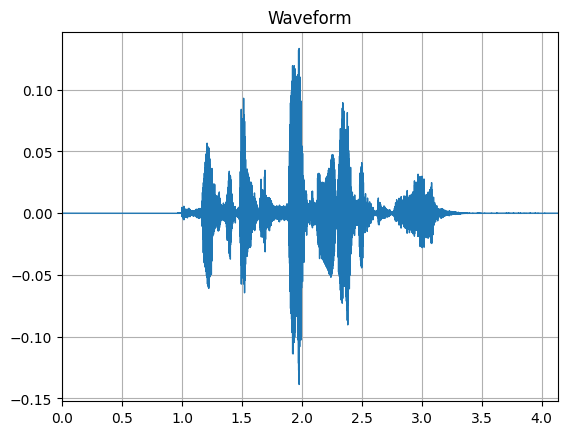

In [10]:
sec=waveform/sample_rate
plot_waveform(waveform, sample_rate)


# Mel Spectrogram
Mel Spectrogram. Spettrogramma Mel. Utilizzare le trasformazioni di Torchaudio per trasformare i dati campione in un'immagine, ovvero lo spettrogramma Mel. 

In [11]:
!pip install librosa

In [12]:
import torch
import torchaudio
import torchaudio.transforms as T
print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from matplotlib.patches import Rectangle

torch.random.manual_seed(0)

# --- MODIFICA PER IL TUO DATASET ---
# Invece di scaricare l'audio, peschiamo il percorso di un file
# direttamente dal tuo train_dataset usando l'attributo _walker
indice_campione = 1  # Puoi cambiare numero per provare audio diversi
SAMPLE_SPEECH = train_dataset._walker[indice_campione]

print(f"File audio selezionato : {SAMPLE_SPEECH}")
# -----------------------------------

# Ora SAMPLE_SPEECH contiene un percorso valido (es. /kaggle/input/.../03-01-05...wav)
# e tutto il codice del tutorial funzionerà perfettamente da qui in avanti!

2.9.0+cu126
2.9.0+cu126
File audio selezionato : /kaggle/input/datasets/uwrfkaggler/ravdess-emotional-speech-audio/Actor_02/03-01-07-02-01-02-02.wav


Shape of Mel spectrogram (dB): torch.Size([1, 128, 414])
Sample rate of waveform: 16000 Hz


/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


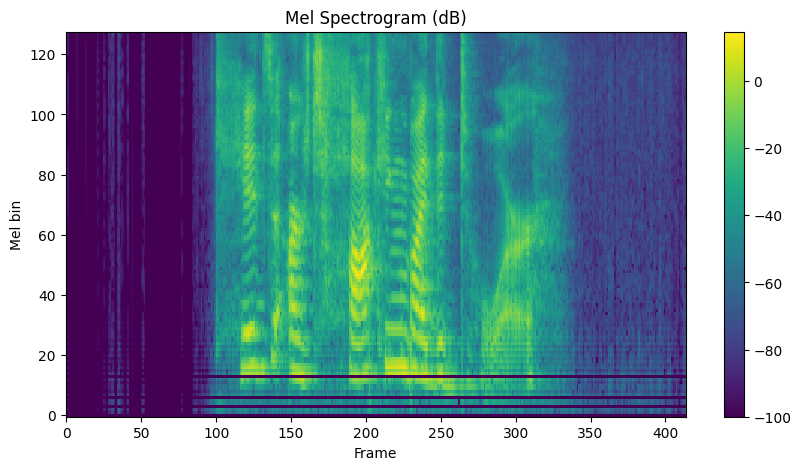

In [13]:
# TASK. MEL SPECTROGRAM
from IPython.display import Audio
from matplotlib.patches import Rectangle
# The download_asset function has been removed in recent torchaudio versions.
# We will use the SAMPLE_SPEECH defined in the previous cell which points to a local file.

#torch.random.manual_seed(0)

# Load audio using the SAMPLE_SPEECH path from the previous cell
# SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Fix: Use the waveform and sample_rate already loaded from the dataset (from cell JcGUx8sUD3xK)
# These variables are globally available in the kernel after executing JcGUx8sUD3xK
SPEECH_WAVEFORM = waveform
SAMPLE_RATE = sample_rate
n_fft = 400 # Example: 25ms window for 16kHz corresponds to 400 samples (0.025 * 16000)
win_length = None #lunghezza frame
hop_length = 160 # Example: 10ms hop length (tempo finestra ms*freqeunza campionamento=0.010 * 16000)
n_mels=128 # Example number of mel bands

# Define the Mel Spectrogram transform and AmplitudeToDB transform as per the task
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
)
amplitude_to_db_transform = T.AmplitudeToDB()

# Perform transform: first MelSpectrogram, then convert to dB
mel_spec = mel_spectrogram_transform(SPEECH_WAVEFORM)
dbmelspec = amplitude_to_db_transform(mel_spec)

print("Shape of Mel spectrogram (dB): {}".format(dbmelspec.shape))

print("Sample rate of waveform: {} Hz".format(sample_rate))

plt.figure(figsize=(10,5))
plt.xlabel('Frame');
plt.ylabel('Mel bin');
plt.imshow(dbmelspec[0], origin="lower", aspect="auto", interpolation="nearest")
plt.colorbar()
plt.title("Mel Spectrogram (dB)")
plt.show()


In [14]:
# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

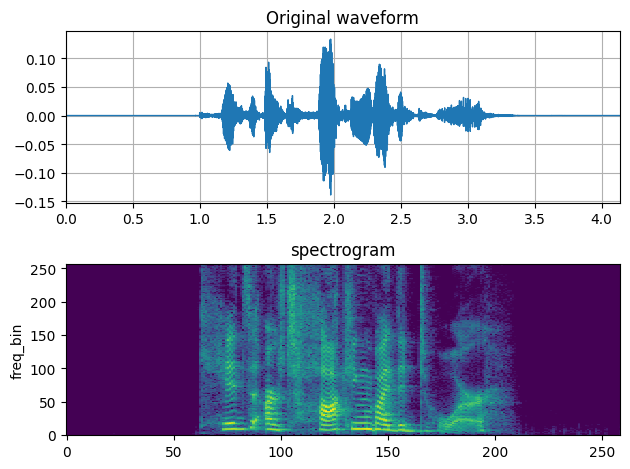

In [15]:
fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

In [16]:
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

## Formatting the data
Functions `label_to_index` and `index_to_label` are used to map (and encode) each word with its index in the list of labels.

In [17]:
import torch

# Assumendo che questa sia la tua mappa (sostituiscila con quella reale del tuo dataset!)
emotion_map = {0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry'}

# 1. Creiamo la mappa inversa e mettiamo tutto in minuscolo per sicurezza
inverse_emotion_map = {v.lower(): k for k, v in emotion_map.items()}

def label_to_index(word):
    # Convertiamo la parola in minuscolo e cerchiamo l'ID
    word = word.lower()
    idx = inverse_emotion_map[word]
    return torch.tensor(idx)

def index_to_label(index):
    # Se index è un tensore di PyTorch, estraiamo il numero intero con .item()
    if torch.is_tensor(index):
        index = index.item()
        
    # Restituiamo la parola (o "Sconosciuto" se il numero non c'è)
    return emotion_map.get(index, f"Sconosciuto ({index})")

# --- TEST DEL CODICE ---
word_start = 'Calm'
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(f"{word_start} --> {index} --> {word_recovered}")

Calm --> 1 --> calm


In [18]:
import torch
import torchaudio

# --- DEFINISCI LA TRASFORMAZIONE FUORI DALLA FUNZIONE ---
# Scegli i parametri adatti al tuo sample rate (es. 16000 o 22050)
sample_rate = 16000 
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_rate,
    n_mfcc=40,
    melkwargs={
        "n_fft": 512,       # Il famoso parametro di cui parlavamo prima!
        "n_mels": 64,
        "hop_length": 160,
    }
)

def pad_sequence(batch):
    # Uniforma le lunghezze delle WAVEFORM (aggiungendo zeri)
    # Funziona per audio 1D: [canali, tempo]
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    # ATTENZIONE QUI: Adatta questa riga in base a cosa restituisce il tuo Dataset!
    # Se il tuo dataset fa: return waveform, label
    # allora scrivi: for waveform, label in batch:
    for data in batch:
        waveform = data[0] # Il primo elemento è l'audio
        label = data[1]    # Il secondo è l'etichetta (o il terzo, a seconda del tuo dataset)
        
        tensors.append(waveform)
        targets.append(label_to_index(label))

    # 1. Raggruppa e fai il padding sulle waveform grezze
    padded_waveforms = pad_sequence(tensors)
    
    # 2. TRASFORMAZIONE IN MFCC (o SPETTROGRAMMA)
    # Passiamo l'intero batch di audio alla trasformazione. 
    # Otterremo tensori 3D: [batch_size, canali, n_mfcc, tempo]
    mfcc_tensors = mfcc_transform(padded_waveforms)
    
    targets = torch.stack(targets)

    # Restituiamo gli MFCC, pronti per essere ingurgitati da una CNN!
    return mfcc_tensors, targets


# --- IL RESTO DEL CODICE RIMANE UGUALE ---
batch_size = 64 # Ti consiglio di abbassarlo un po' rispetto a 256, gli MFCC pesano di più!

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn, # Ora questa userà la nostra nuova versione!
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Generic functions for training and testing the network model

Now let’s define a *generic* training function that will feed our training data into the model and perform the backward pass and optimization steps. The network will then be tested after each epoch to see how the accuracy varies during the training.

The *generic* function receives as parameters:
* The **trasform** function to apply to the data (or `None`).
* The **criterion** function for computing the loss.
* The **optimizer** to be used during the process.